TODO: 1.teams -> capacity
      
      2. district colors plotting in JS
      
      3. a summary function in Partition
      
      4. instead of saving data and passing it to falcomplot.animation, 
      
      find a way to pass the optimizer including data and chain stat.

1. Candidate selection and plotting: Integrate this into Graph class. A candidate plot function
    grid populations, real and artificial candidates, other info
    plot and show all info in hover
2. Travel time calculations: Calculate it using R.  Need a plot function for this?

3. Tree saving and plotting: Fix the batch function. Complete the JS animation
4. Code the optimization part.
5. Find a method for random walk and code it up.
6. Read the routing paper.


In [ ]:
import numpy as np
import geopandas as gpd
 
#import pickle 
#import random
#import json

from functools import partial
from types import MappingProxyType
#from tqdm import tqdm

from helper import DataHandler #add_to_data, add_to_graph, save_pickle, load_pickle
from functools import partial

from partition import Partition, Assignment
#from grid import Grid
from markovchain import SingleMetricOptimizer, hierarchical_recom

"Load data"

handler = DataHandler()
#graph = handler.load_graph()
graphhh = handler.load_graphhh()
#chicago = handler.load_chicago()
chicagooo = handler.load_chicagooo()
#candidates = handler.load_candidates()  # set of nodes
#travel_times_walking = handler.load_travel_walking()
#travel_times = handler.load_travel_times() # travel time between blocks is 10 minutes
#newtravel = handler.load_newtravel()
real_travel_times = handler.load_real_travel_times()


One problem: we always pick a superdistrict and omit mixing districts between superdistricts. Change the figure.

In [ ]:
# capacity level 2

import json
path = "/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/JS-plots/data/trees-old/tree_547.json"
with open(path, 'r') as f:
        tree_json = json.load(f)

under_100 = 0
num_100 = 0
num_200 = 0
num_300 = 0
num_400 = 0
num_500 = 0
num_1000 = 0
num_1500 = 0
num_2000 = 0
num_2500 = 0
extremes = {}

epsilon = tree_json["metadata"]["epsilon"]
pop_target = tree_json["metadata"]["ideal_pop"]

interval_one = [(1-epsilon) * pop_target, (1+epsilon) * pop_target]
interval_two = [(1-epsilon) * pop_target * 2, (1+epsilon) * pop_target * 2]

for node_dict in tree_json["nodes"]:
    node = int(node_dict["id"])
    pop = graphhh.nodes[node]['population']
    
    if pop <= 100:
        under_100 += 1
    if pop >100:
        num_100 += 1
    if pop >200:
        num_200 += 1
    if pop >300:
        num_300 += 1
    if pop >400:
        num_400 += 1
    if pop > 500:
        num_500 += 1
    if pop > 1000:
        num_1000 += 1
    if pop > 1500:
        num_1500 += 1
    if pop > 2000:
        num_2000 += 1
    if pop > 2500:
        num_2500 += 1
        extremes[node] = pop         

print("total num of nodes ->", len(tree_json["nodes"]))
print("under 100 ->", under_100)    
print(">100->", num_100)
print(">200->", num_200)
print(">300->", num_300)
print(">400->", num_400)
print(">500->", num_500)
print(">1000->", num_1000) 
print(">1500->", num_1500) 
print(">2000->", num_2000) 
print(">2500->", num_2500)    
print("extremes ->", extremes)

print("--------------------------")
print("leftover population", tree_json["metadata"]["tot_pop"])
print("population target", pop_target)
print("pop interval for one team", interval_one)
print("pop interval for two teams", interval_two)

total num of nodes -> 739
under 100 -> 606
>100-> 133
>200-> 29
>300-> 13
>400-> 8
>500-> 4
>1000-> 2
>1500-> 2
>2000-> 2
>2500-> 2
extremes -> {17159: 3283, 5158: 4689}
--------------------------
leftover population 52921
population target 1559.75
pop interval for one team [1469.4999999999998, 1650.0000000000002]
pop interval for two teams [2938.9999999999995, 3300.0000000000005]


In [ ]:
"Initial partition"

graphhh.nodes[5158]["population"] = 100
graphhh.nodes[17159]["population"] = 100
pop = sum(graphhh.nodes[node]['population'] for node in graphhh.nodes)
#area = sum(graph.nodes[node]['area'] for node in graph.nodes)   
#avg_density = area / pop
# nodelarin density check i burda yapilip sonuc attribute olarak atansin. Attribute ismi simdilik density
#check_density = ?

Assignment.travel_times = MappingProxyType(real_travel_times)

"""try:"""
initial_solution = Partition.from_random_assignment(
graph=graphhh, 
assignment_class=Assignment,
capacity_level = 3,
epsilon=0.1,
pop_target = 1500,
#density = 0.5,
snapshot=True
)
"""except Exception as e:
    print(f"\nCaught the error. Entering debugger.")
    # This will drop you into an interactive debugging session
    %debug """


In [ ]:
"Plot initial partition"
#m, regions, chicago, geocenters = initial_solution.plot_map(attr="district")
#m
from falcomchain.helper.plot import Plot

plt = Plot()
"Plot side by side"
fig, regions_initial_new, regions_final_new, centers, others = plt.compare(initial_partition=initial_solution, final_partition=initial_solution)
fig

In [ ]:
m.save("map0.html")

In [2]:
Assignment.travel_times = MappingProxyType(real_travel_times)
initial_solution = Partition.load_partition(assignment_class=Assignment)

In [5]:
path = '/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/data/instances/selected_blocks_20251122_213138.pkl'

from falcomchain.helper import load_pickle
df = load_pickle(path)
del df['centroid_geo']



In [11]:
dis = [part for part in initial_solution.teams if initial_solution.teams[part] == 1]

In [ ]:
part_1 = dis[0]
part_2 = dis[1]
part_3 = dis[2]
nodes = initial_solution.parts[part]

new = chicagooo.loc[chicagooo.index.isin(nodes)]

In [12]:
df = chicagooo.copy()

for col in df.columns:
    if col != 'geometry':
        del df[col]
        

In [ ]:
import pandas
import geopandas
import matplotlib.pyplot as plt
def to_series(self):
    """
    :returns: The assignment as a :class:`pandas.Series`.
    :rtype: pandas.Series
    """
    groups = [
        pandas.Series(data=part, index=nodes) for part, nodes in self.parts.items()
    ]
    return pandas.concat(groups)
    
def plot(geometries, assignment, graph, **kwargs):
    """
    Plot the partition, using the provided geometries.

    :param geometries: A :class:`geopandas.GeoDataFrame` or :class:`geopandas.GeoSeries`
        holding the geometries to use for plotting. Its :class:`~pandas.Index` should match
        the node labels of the partition's underlying :class:`~gerrychain.Graph`.
    :type geometries: geopandas.GeoDataFrame or geopandas.GeoSeries
    :param `**kwargs`: Additional arguments to pass to :meth:`geopandas.GeoDataFrame.plot`
        to adjust the plot.

    :returns: The matplotlib axes object. Which plots the Partition.
    :rtype: matplotlib.axes.Axes
    """

    if set(geometries.index) != set(graph.nodes):
        raise TypeError(
            "The provided geometries do not match the nodes of the graph."
        )
    assignment_series = assignment.to_series()
    if isinstance(geometries, geopandas.GeoDataFrame):
        geometries = geometries.geometry
    df = geopandas.GeoDataFrame(
        {"assignment": assignment_series}, geometry=geometries
    )
    return df.plot(column="assignment", **kwargs)



In [63]:
import random
supergraph = initial_solution.supergraph

In [67]:
node = random.choice(list(supergraph.nodes))
neigh = list(supergraph.neighbors(node))
neigh

[304, 153]

In [68]:
neigh.append(node)
neigh

[304, 153, 151]

In [69]:
nodes = []
for part in neigh:
    nodes.extend(list(initial_solution.parts[part])) 

len(nodes)

109

In [70]:
new = chicagooo.loc[chicagooo.index.isin(nodes)]

In [ ]:
new['new_color'] = 0
new['new_color'] = [initial_solution.assignment.mapping[index] for index in new.index]
new['new_color']

In [88]:
ins = load_pickle('/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/data/instances/selected_blocks_20251122_213107.pkl')
nodes = {node for node in ins.index if node in graphhh.nodes}
ins = ins.loc[ins.index.isin(nodes)]

for col in ins.columns:
    if col != 'geometry':
        del ins[col]

In [90]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri

<Axes: >

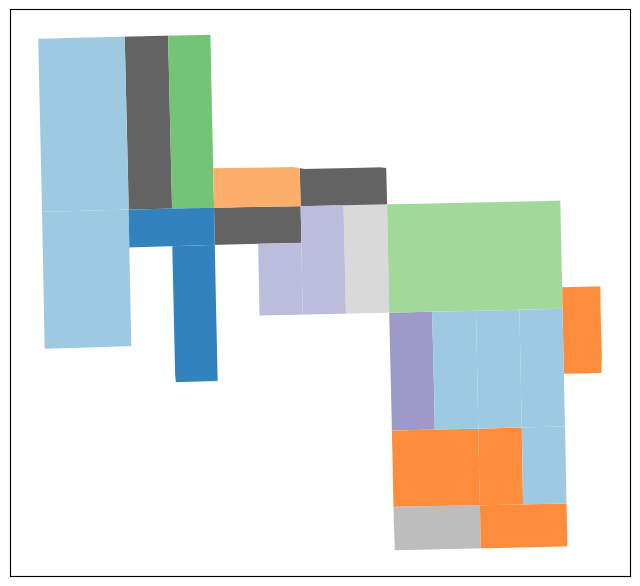

In [94]:


G = graphhh.subgraph(nodes)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_yticks([])
ax.set_xticks([])
plot(geometries=ins, assignment=initial_solution.assignment, graph=G, ax=ax, cmap='tab20c_r')

In [8]:
# prepare a summary function in partition

num_districts_with_1 = sum(1 for part in initial_solution.teams if initial_solution.teams[part] == 1)
num_districts_with_2 = sum(1 for part in initial_solution.teams if initial_solution.teams[part] == 2)
num_districts_with_3 = sum(1 for part in initial_solution.teams if initial_solution.teams[part] == 3)

print(num_districts_with_1)
print(num_districts_with_2)
print(num_districts_with_3)

337
140
72


In [3]:
from falcomchain.constraints import within_percent_of_ideal_population


"Proposal and constraints"   # See how we call this in optimizer. 
proposal = partial(
    hierarchical_recom,
    epsilon=0.1,
    pop_target=1500,
    density = None,
    snapshot=True)
constraints = within_percent_of_ideal_population(initial_solution)


"Optimizer"
#sum_travel_radius = lambda p: np.sum(p.radius.values())
#num_cut_edges = lambda p: len(p["cut_edges"])
average_radius = lambda p: np.sum(((np.array(list(p.radius.values())) - np.sum(list(p.radius.values())) / len(p))**2))

optimizer = SingleMetricOptimizer(
    proposal=proposal,
    constraints=constraints,
    initial_state=initial_solution, 
    optimization_metric=average_radius,
    maximize=False)

In [ ]:
total_steps = 10000

# Short Bursts
min_scores_sb = np.zeros(total_steps)
scores_sb = np.zeros(total_steps)
for i, part in enumerate(optimizer.short_bursts(5, 2000, with_progress_bar=True)):
    min_scores_sb[i] = optimizer.best_score
    scores_sb[i] = optimizer.score(part)


# Tilted Runs
min_scores_tilt = np.zeros(total_steps)
scores_tilt = np.zeros(total_steps)
for i, part in enumerate(optimizer.tilted_run(total_steps, p=0.125, with_progress_bar=True)):
    print("state", i)
    min_scores_tilt[i] = optimizer.best_score
    scores_tilt[i] = optimizer.score(part)

In [ ]:
total_steps = 10000

"""# Short Bursts
min_scores_sb = np.zeros(total_steps)
scores_sb = np.zeros(total_steps)
for i, part in enumerate(optimizer.short_bursts(5, 2000, with_progress_bar=True)):
    min_scores_sb[i] = optimizer.best_score
    scores_sb[i] = optimizer.score(part)


# Tilted Runs
min_scores_tilt = np.zeros(total_steps)
scores_tilt = np.zeros(total_steps)
for i, part in enumerate(optimizer.tilted_run(total_steps, p=0.125, with_progress_bar=True)):
    min_scores_tilt[i] = optimizer.best_score
    scores_tilt[i] = optimizer.score(part)"""
    

# Simulated Annealing
min_scores_anneal = np.zeros(total_steps)
scores_anneal = np.zeros(total_steps)
for i, part in enumerate(
    optimizer.simulated_annealing(
        total_steps,
        optimizer.jumpcycle_beta_function(200, 800),
        beta_magnitude=1,
        with_progress_bar=True)
    ):
    min_scores_anneal[i] = optimizer.best_score
    scores_anneal[i] = optimizer.score(part)

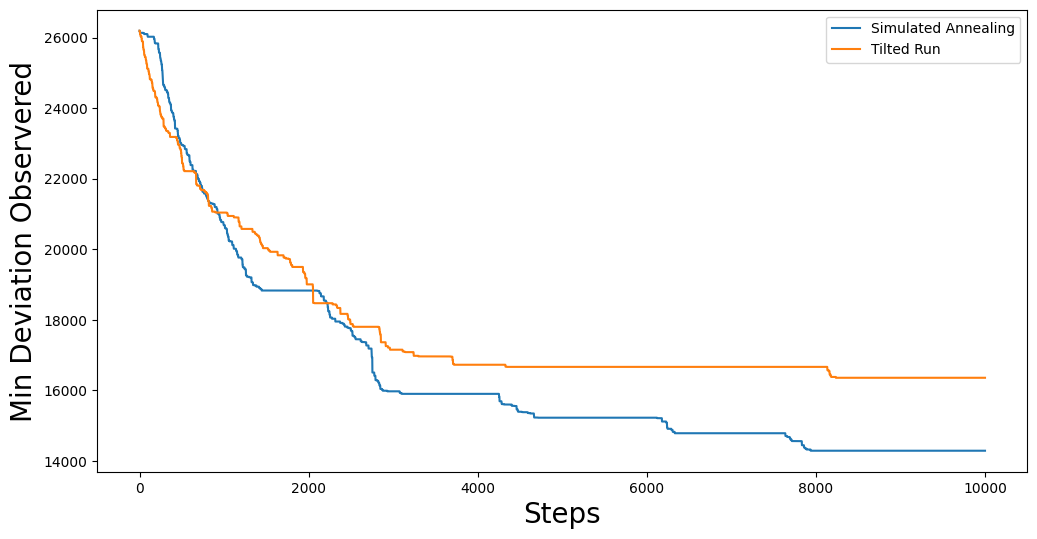

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,6))
#plt.plot(min_scores_sb, label="Short Bursts")
plt.plot(min_scores_anneal, label="Simulated Annealing")
plt.plot(min_scores_tilt, label="Tilted Run")
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Min Deviation Observered", fontsize=20)
plt.legend()
plt.show()

In [ ]:
# In your Jupyter Notebook cell
#from falcomchain.partition import supergraph
from falcomchain.markovchain import hierarchical_recom
from falcomchain.tree import bipartition_tree
# Load the debugger magic command
%pdb on 

total_steps = 1000
partitions = {}
min_scores_tilt = np.zeros(total_steps)

# The exception will be raised from within this loop
for i, part in enumerate(optimizer.tilted_run(total_steps, p=0.125, with_progress_bar=True)):
    try:
        min_scores_tilt[i] = optimizer.best_score
        partitions[i] = optimizer.best_part

        # Call your function here, which will re-raise the error
        
        hierarchical_recom(partition) # Pass the current part object being generated
        
    except Exception as e:
        print(f"\nCaught the error on step {i}. Entering debugger.")
        # This will drop you into an interactive debugging session
        %debug 
        break # Exit the loop after debugging if you want

## Two problems
# 1. To update super district names, we need to give an assignment of supernodes in proposal
# 2. If we will run the recursive tree cut for the whole supergraph, then we need to use dynamic epsilons

Automatic pdb calling has been turned ON


  0%|          | 0/1000 [00:00<?, ?it/s]


Caught the error on step 0. Entering debugger.


In [ ]:
import sys
from dataclasses import dataclass, field
from typing import Any, Dict, Set


# The revised logic:

MAX_TRIES = 100
cut_object = None
original_exception = None

for attempt in range(MAX_TRIES):
    # Dynamically change the density parameter for each attempt
    # The value of density should change in a meaningful way specific to your use case
    # For example, decreasing density slightly each time
    current_density = density - (attempt * some_step_value) # You need to define how density changes
    
    try:
        cut_object = bipartition_tree(
            graph.subgraph(remaining_nodes),
            column_names=column_names,
            pop_target=new_pop_target,
            capacity_level=capacity_level,
            n_teams=remaining_teams,
            epsilon=new_epsilon,
            two_sided=two_sided,
            supergraph=supergraph,
            # Use the current density for this attempt
            density=current_density, 
            snapshot=snapshot,
            iteration=iteration,
        )
        # If the call succeeds, break the loop
        break

    except RuntimeError as e:
        # Store the last exception. If the loop finishes without success, this will be raised.
        original_exception = e
        print(f"Attempt {attempt + 1}/{MAX_TRIES} failed with RuntimeError. Retrying with different density.")
        # Continue to the next iteration of the loop to try a new density
        continue 
    except Exception:
        # Handle other unexpected exceptions immediately if they are not the target RuntimeError
        raise

# After the loop finishes:

if cut_object is None:
    # If we tried MAX_TRIES times and still couldn't find a valid cut_object
    print(f"All {MAX_TRIES} attempts failed. Re-raising the original RuntimeError.")
    if original_exception:
        # Re-raise the original exception caught in the last attempt
        raise original_exception
    else:
        # Fallback if somehow no exception was captured but cut_object is None
        raise RuntimeError("bipartition_tree failed repeatedly for an unknown reason.")
else:
    # If we successfully found a cut_object, proceed with the rest of the program
    print("Successfully found a valid cut_object.")
    # You can now use cut_object for subsequent operations


In [8]:
for part in initial_solution.parts.keys():
    pop = initial_solution.part_pop(part)
    if pop == 4149:
        print(part)

In [9]:
parts= {252, 332, 503}
print(sum(initial_solution.part_pop(part) for part in parts))
for part in parts:
    print(len(initial_solution.candidates[part]))

4149
7
2
5


In [10]:
e = 0.1
count = 0
for part in initial_solution.parts.keys():
    pop = initial_solution.part_pop(part)
    teams = initial_solution.teams[part]
    if 1500*teams - e*1500*teams <= pop <= e*1500*teams + 1500*teams:
        continue
    else:
        count +=1
        print(pop, teams,  (pop - 1500*teams))
print("total", count)

total 0


In [13]:
len(initial_solution.parts)

549

In [12]:
e = 0.1
count = 0
for part in initial_solution.parts.keys():
    pop = initial_solution.supergraph.nodes[part]["population"]
    teams = initial_solution.teams[part]
    if 1500*teams - e*1500 -50<= pop <= e*1500 + 1500*teams +50:
        continue
    else:
        print(pop, teams,  (pop - 1500*teams, "district", part))


4719 3 (219, 'district', 27)
4744 3 (244, 'district', 74)
3213 2 (213, 'district', 121)
4718 3 (218, 'district', 169)
4769 3 (269, 'district', 183)
2797 2 (-203, 'district', 430)
4750 3 (250, 'district', 470)
4741 3 (241, 'district', 500)
4759 3 (259, 'district', 545)


In [6]:
import json
import os
from pathlib import Path

path = "/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/JS-app/data/trees"
i=1

base = Path(path)
base.mkdir(parents=True, exist_ok=True)





while i <= 549:  
    path = base / f"tree_{1}.json"  
    with open(path, 'r') as f:
        tree = json.load(f)    # spanning tree dictionary
        
    if tree["metadata"]["n_teams"] <= 3:
        print("iteration", i)
        print(tree["metadata"])
    i+=1

In [7]:
path_d = "/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/JS-app/data/districts"
base = Path(path_d)
e=0.1
weird = set()
for i in range(1, 550):
    path= base / f"district_{i}.json"  
    
    with open(path, 'r') as f:
        district = json.load(f)


    pop = district["metadata"]["tot_pop"] 
    teams = district["metadata"]["hired_teams"]
    if not 1500*teams - e*1500 <= pop <= e*1500 + 1500*teams:
        weird.add(i)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/JS-app/data/districts/district_6.json'

In [5]:
path_t = "/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/JS-app/data/trees"
path_d = "/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/JS-app/data/districts"

base_t = Path(path_t)
base_d = Path(path_d)
weird_sorted = sorted(list(weird))
for i in weird_sorted:
    path_1= base_t / f"tree_{i}.json" 
    path_2= base_d / f"district_{i}.json" 
    path_3= base_t / f"tree_{i+1}.json"  
    
    with open(path_1, 'r') as f:
        tree_i = json.load(f)
    with open(path_2, 'r') as f:
        district_i = json.load(f)
    with open(path_3, 'r') as f:
        tree_ii = json.load(f)
    

    pop_tree_i = tree_i["metadata"]["tot_pop"] 
    teams_i = tree_i["metadata"]["n_teams"]
    #eps_d = district_i["metadata"]["'epsilon'"]
    
    pop_d = district_i["metadata"]["tot_pop"] 
    teams_d = district_i["metadata"]["hired_teams"]
    #eps_d = district_i["metadata"]["'epsilon'"]
    
    pop_tree_ii = tree_ii["metadata"]["tot_pop"] 
    teams_ii = tree_ii["metadata"]["n_teams"]
    
    error_i = pop_tree_i - teams_i*1500
    error_d = pop_d - teams_d*1500
    error_ii = pop_tree_ii - teams_ii*1500
    

     
    print(f"before the cut, error was {error_i} for {teams_i} teams")
    print(f"district has the error {error_d} for {teams_d} teams")
    print(f"after the cut, error became {error_ii} for {teams_ii} teams")
    print(tree_i["metadata"])
    print(district_i["metadata"])
    print(tree_ii["metadata"])
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------")



NameError: name 'Path' is not defined

In [39]:

pop = 4759
ideal_pop = 1572.5
e = 0.1

a = pop - 3 * ideal_pop
a

41.5

In [42]:
(ideal_pop - 1500) 

72.5

In [ ]:
 def has_ideal_pop(self, assign_team, pop):
        return (
            abs(pop - assign_team * self.ideal_pop)
            <= self.ideal_pop * self.epsilon
        )

    def complement_has_the_ideal_pop(self, assign_team, pop):
        return (
            abs((self.tot_pop - pop) - assign_team * self.ideal_pop)
            <= self.ideal_pop * self.epsilon

In [16]:
if 36138 in initial_solution.parts[545]:
    print("yes")

yes


In [17]:
path_4= base_t / f"tree_{545}.json"  
    
with open(path_4, 'r') as f:
    tree = json.load(f)

In [22]:
edge_list = []
for edge_dict in tree['links']:
    u = int(edge_dict['source'])
    v = int(edge_dict['target'])
    edge_list.append((u,v))
print(edge_list)

[(2048, 33702), (2048, 19306), (2048, 17781), (2049, 10739), (2049, 11513), (12802, 1899), (13826, 25901), (13826, 8764), (13828, 13829), (13828, 25773), (13828, 25411), (13829, 7142), (13829, 34781), (13829, 18232), (13829, 25901), (13830, 11504), (20998, 26891), (5653, 6103), (5653, 4364), (29205, 32006), (29205, 36227), (29205, 9568), (29206, 11513), (29206, 9568), (29212, 6706), (29212, 25811), (29212, 35046), (14879, 29373), (25127, 32009), (25130, 6224), (8747, 32362), (33323, 11513), (3120, 36137), (6706, 14119), (34868, 33266), (34868, 21294), (34868, 20445), (34868, 35022), (34869, 33266), (10809, 34382), (8764, 26441), (31805, 32014), (31805, 27724), (30276, 30816), (30276, 11513), (30276, 32015), (10825, 29872), (10825, 39189), (27723, 34250), (27724, 34249), (27724, 25797), (27724, 17781), (34382, 29866), (34382, 34384), (6224, 24908), (8272, 29375), (8272, 24197), (1109, 26441), (7260, 34485), (7260, 18726), (7260, 36136), (7260, 17502), (7260, 26554), (5726, 14016), (1750

In [27]:
import networkx as nx
G = nx.from_edgelist(edge_list)
root = 36138
print(G.degree(root))

3


In [26]:
sum(graphhh.nodes[node]['candidate'] for node in G.nodes)
    

25

In [31]:
comp = set(G.nodes) - nodes
sum(graphhh.nodes[node]['population'] for node in comp)

4759

pop, teams, pop - 1500*teams, "district", part

4719 3 (219, 'district', 27)
4744 3 (244, 'district', 74)
3213 2 (213, 'district', 121)
4718 3 (218, 'district', 169)
4769 3 (269, 'district', 183)
2797 2 (-203, 'district', 430)
4750 3 (250, 'district', 470)
4741 3 (241, 'district', 500)
4759 3 (259, 'district', 545)

In [4]:
for i in range(1, 550):
    path_2= base_d / f"district_{i}.json"  
    
    with open(path_2, 'r') as f:
        district = json.load(f)


    debt = district["metadata"]["debt"] 
    print(debt, f"iteration {i}")

 debt += pop - pop_target * hired_teams 

IndentationError: unindent does not match any outer indentation level (<string>, line 11)

In [ ]:
for i in range(1, 543):
tree["metadata"]["n_teams"]
    if 1500*teams - e*1500 <= pop <= e*1500 + 1500*teams == False:
        print(tree["metadata"])
    
    for part in initial_solution.parts.keys():
    pop = initial_solution.supergraph.nodes[part]["population"]
    teams = initial_solution.teams[part]

In [ ]:
metadata = {
        "ideal_pop": _to_py(getattr(tree, "ideal_pop", None)),
        "root": str(getattr(tree, "root", "")),
        "n_teams": _to_py(getattr(tree, "n_teams", None)),
        "epsilon": _to_py(getattr(tree, "epsilon", None)),
        "two_sided": _to_py(getattr(tree, "two_sided", None)),
        "tot_candidates": _to_py(getattr(tree, "tot_candidates", None)),
        "tot_pop": _to_py(getattr(tree, "tot_pop", None)),
    }

initial_solution['population']

for p in base.glob("tree_*.json"):  # or "*.json"
    try:
        p.unlink()
    except FileNotFoundError:
        pass

In [ ]:
"Plot side by side"
fig, regions_initial_new, regions_final_new, centers, others = plt.compare(initial_partition, final_partition)
fig


# Last result for average radius with fixed travel time

In [ ]:
import matplotlib.pyplot as mplt
fig, ax = mplt.subplots(figsize=(12,6))
mplt.plot(min_scores_tilt, label="Tilted Run")
mplt.xlabel("Steps", fontsize=20)
mplt.ylabel("Sum of radius_average", fontsize=20)
mplt.legend()
mplt.show()

In [ ]:
"Plot side by side"
fig, regions_initial_new, regions_final_new, centers, others = plt.compare(initial_partition, final_partition)
fig

In [ ]:
#sum_travel_radius = lambda p: np.sum(p.radius.values())
num_cut_edges = lambda p: len(p["cut_edges"])
average_radius = lambda p: np.sum(abs((np.array(list(p.radius.values())) - np.sum(list(p.radius.values())) / len(p))**2))

In [ ]:
import gerrytools

import matplotlib.pyplot as plt
from gerrytools.scoring import *
from gerrytools.plotting import *
import gerrytools.plotting.colors as colors
import numpy as np

N = len(regions_final_new)

dists = regions_final_new.to_crs("EPSG:3857")
dists["final_district"] = dists["final_district"].astype(int)
dists=dists.sort_values(by="final_district")
dists["colorindex"] = list(range(N))
dists["color"] = colors.districtr(N)

ax = drawplan(chicago, assignment="final_district", overlays=None)

In [ ]:
import maup
from maup import repair

In [ ]:
maup.doctor(chicago)

In [ ]:
repair.count_holes(chicago)

In [ ]:
maup.repair.autorepair(chicago)

In [ ]:
final_partition.plot(chicago, figsize=(10, 10), cmap="tab20")
mplt.axis('off')
mplt.show()

In [ ]:
import numpy as np
print("1) Number of Cut Edges")
print("    Best score: ", optimizer.best_score)
print("    Initial score: ", len(initial_partition["cut_edges"]))
print("2) Sum of Travel Radius")
print("    Initial: ", np.sum(list(initial_partition.radius.values())))
print("    Final: ", np.sum(list(final_partition.radius.values())))
print("3) Sum of Radius Devitation")
print("    Initial: ", sum(abs(np.array(list(initial_partition.radius.values())) - sum(x for x in initial_partition.radius.values()) / len(initial_partition))**2))
print("    Final: ", sum(abs(np.array(list(final_partition.radius.values())) - sum(x for x in final_partition.radius.values())/ len(final_partition))**2 ))

In [ ]:
"""pcompress
radiuss = {}
i=0
for optimizer in Record(optimizer.tilted_run(total_steps, p=0.125, with_progress_bar=True), "pa-run.chain"):
    # normal chain stuff here
    partition = optimizer.best_part
    radius = partition.radius
    radiuss[i] = radius 
    i+= 1"""

In [ ]:
"Watch"
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

import pandas as pd

import matplotlib.cm as mcm
import matplotlib.pyplot as mplt
import networkx as nx
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

frames = []
district_data = []

for i, partition in enumerate(recom_chain):
    for district_name in partition.perimeter.keys():
        population = partition.population[district_name]
        perimeter = partition.perimeter[district_name]
        area = partition.area[district_name]
        district_data.append((i, district_name, population, perimeter, area))

    buffer = io.BytesIO()
    fig, ax = plt.subplots(figsize=(10,10))
    partition.plot(ax=ax, cmap='tab20')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image = Image.open(buffer)
    frames.append(image)
    plt.close(fig)

df = pd.DataFrame(
    district_data,
    columns=[
        'step',
        'district_name',
        'population',
        'perimeter',
        'area'
    ]
)

def show_frame(idx):
    clear_output(wait=True)
    display(frames[idx])

slider = widgets.IntSlider(value=0, min=0, max=len(frames)-1, step=1, description='Frame:')
slider.layout.width = '500px'
widgets.interactive(show_frame, idx=slider)
#df.head(5)
#The perimeter and area attributes are actually not present in the MN_precincts.geojson file, but the GeographicPartition class will calculate them at instantiation time using the geometries provided in the file.

# Save

In [ ]:
#final_partition = optimizer.best_part
#for partition in pcompress.Record(optimizer, "run.chain", executable="pv", extreme=True):
#    print(partition.population)

#final_partition = optimizer.best_part
#handler = DataHandler()
#handler.load_final_assignment()
#final_partition = optimizer.best_part
#final_assignment = dict(final_partition.assignment)
#pd.to_pickle(final_assignment, '/Users/kirtisoglu/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/prepared_data/final_assignment.pkl')
#final_assignment = handler.load_final_assignment()
#final_assignment = Partition(graph, final_assignment, updaters=my_updaters)

# Local Search

In [ ]:
# We can run each of the optimization methods and collect some data

total_steps = 10000

# Short Bursts
min_scores_sb = np.zeros(total_steps)
for i, part in enumerate(optimizer.short_bursts(5, 2000, with_progress_bar=True)):
    min_scores_sb[i] = optimizer.best_score

# Simulated Annealing
min_scores_anneal = np.zeros(total_steps)
for i, part in enumerate(
    optimizer.simulated_annealing(
        total_steps,
        optimizer.jumpcycle_beta_function(200, 800),
        beta_magnitude=1,
        with_progress_bar=True
    )
):
    min_scores_anneal[i] = optimizer.best_score